In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pandas as pd

A copula is a function that links univariate marginal distribution functions to form a multivariate distribution, effectively capturing the dependence structure between random variables. According to Sklar's theorem, any multivariate joint distribution can be expressed in terms of its marginals and a copula that describes the dependence between them.

In the provided code, a copula is implemented to model the dependence between three variables with different marginal distributions: Gamma, Exponential, and Chi-squared. The code uses a Gaussian copula, which is constructed from a multivariate normal distribution. This is done by transforming the marginal distributions into a standard normal space, applying the correlation structure, and then transforming back to the original marginal distributions

This two-pass approach allows for flexible modeling of complex dependence structures by decoupling the estimation of marginal distributions from the estimation of their dependencies. 

In the referenced PyMC example, a two-pass approach is used for copula estimation:

First Pass (Marginal Estimation):

Each marginal distribution is estimated separately using Bayesian methods.

Second Pass (Dependence Structure Estimation):

The copula parameters, which capture the dependence structure between the variables, are estimated using the standardized residuals from the first pass.

To use copulas for creating arbitrary multivariate Generalized Linear Models (GLMs):

1. Choose appropriate distributions for each response variable based on their characteristics.

2. Select a copula that represents the dependence structure among the response variables.

3. Use a two-pass approach to first estimate the parameters of the marginal distributions and then the parameters of the copula.

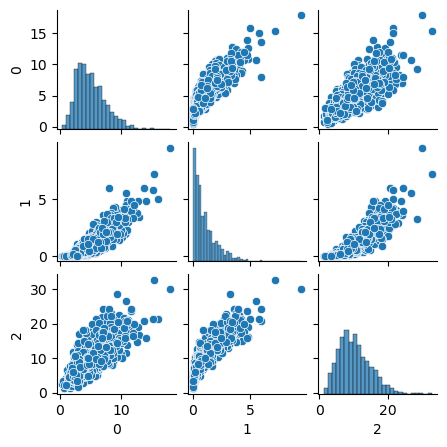

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p0, p1, p2]


Sampling 2 chains for 200 tune and 200 draw iterations (400 + 400 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [R]


Sampling 2 chains for 200 tune and 200 draw iterations (400 + 400 draws total) took 279 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


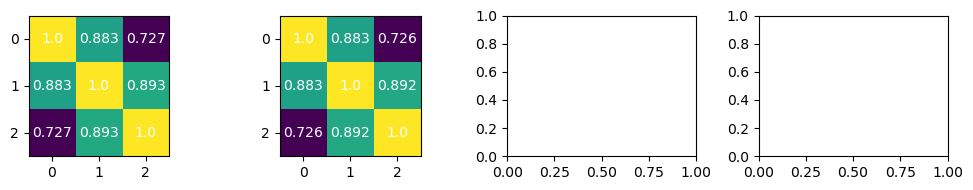

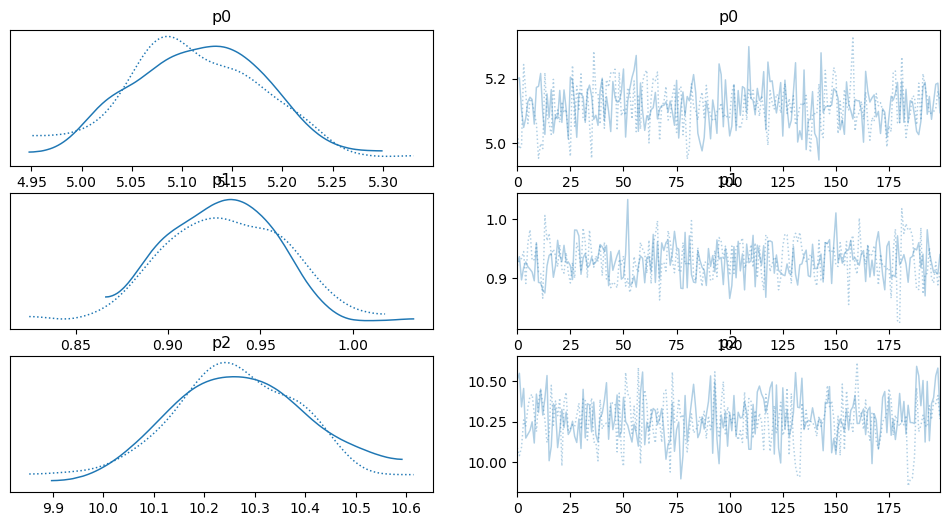

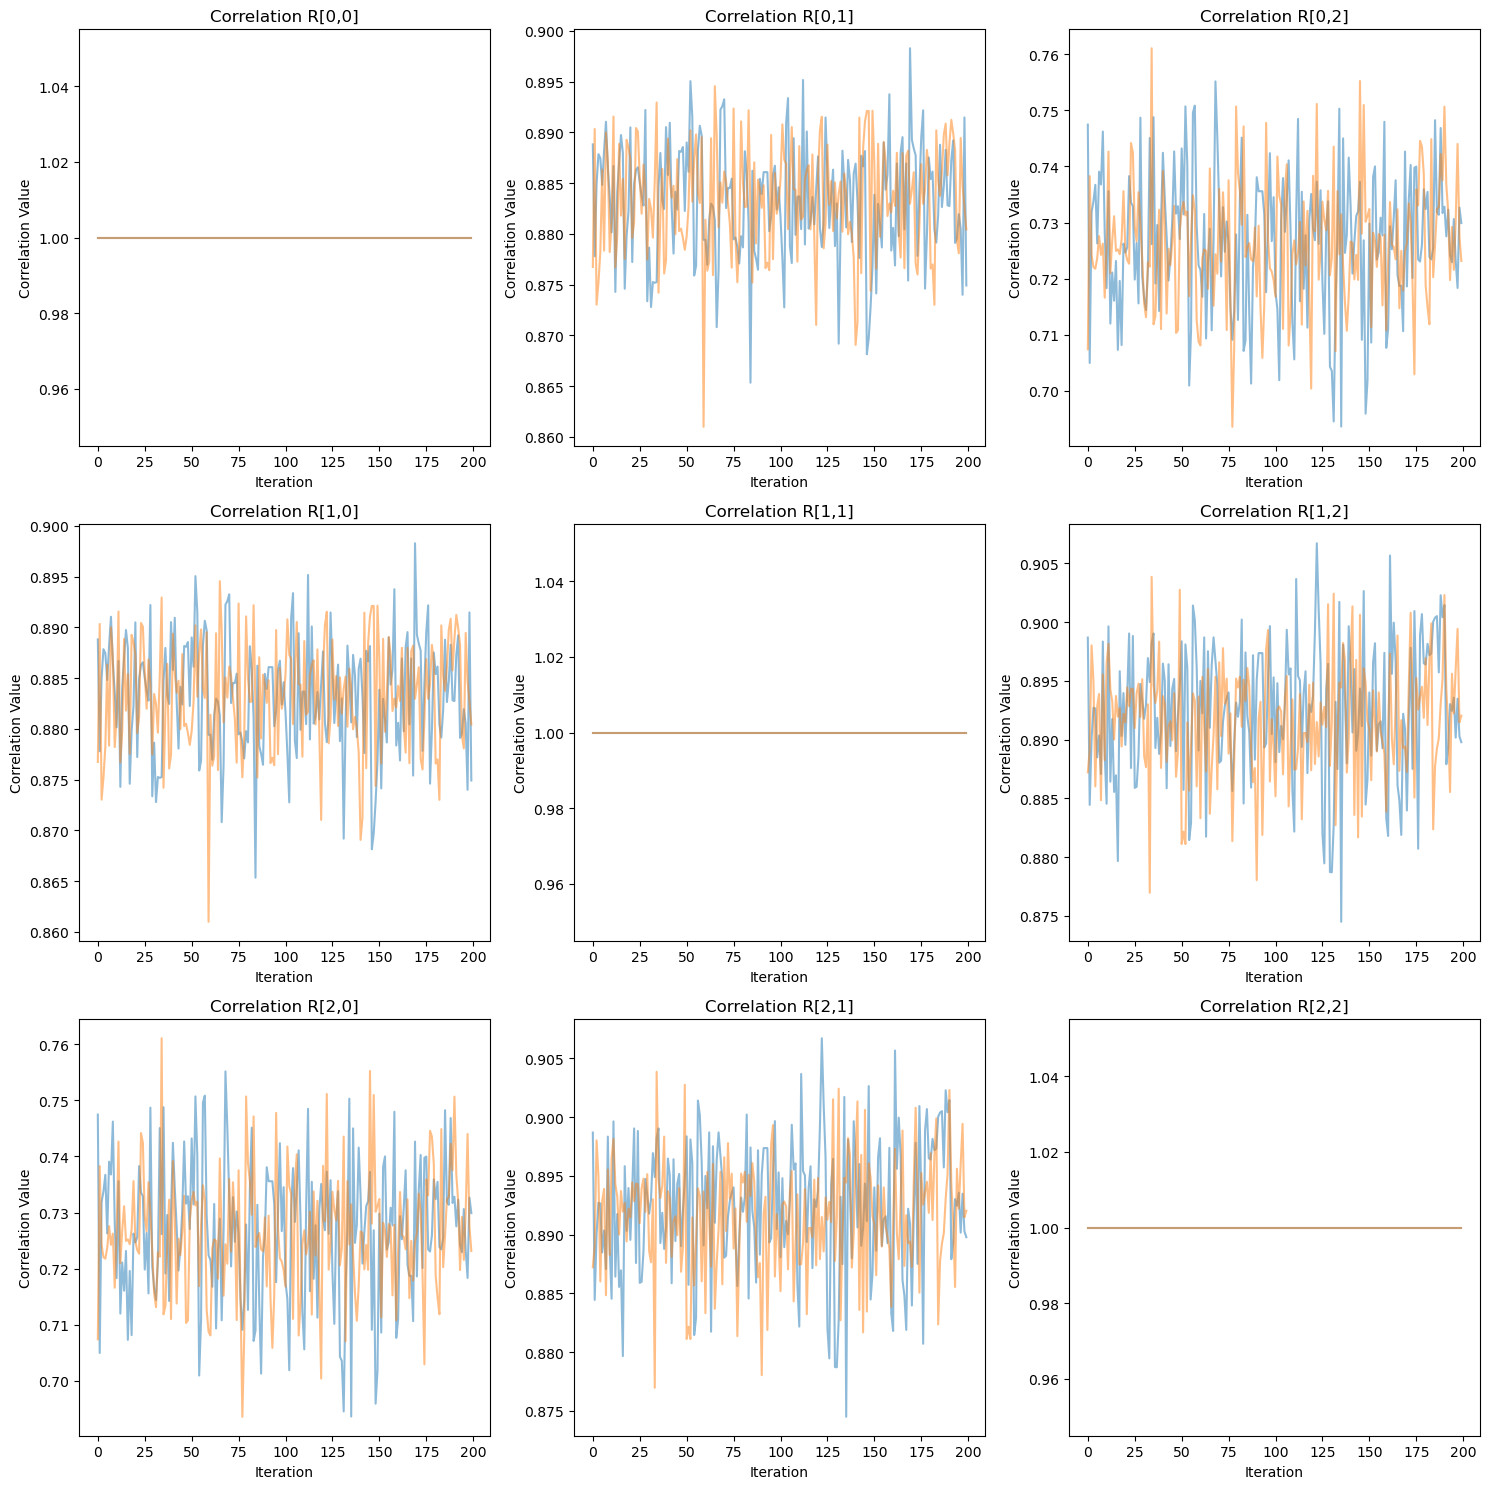

In [7]:
p = 3  
n = 1000  

# Define the correlation matrix
a_cor = (np.ones((p, p)) * 9 + np.diag((1, 1, 1))) / 10
a_cor[0, -1] -= 0.15
a_cor[-1, 0] -= 0.15

# Generate multivariate normal samples
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
u = stats.norm.cdf(x)

# Apply inverse CDF (quantile functions) to get the target distributions
y = np.zeros_like(x)
y[:, 0] = stats.gamma(a=5).ppf(u[:, 0])
y[:, 1] = stats.expon(scale=1).ppf(u[:, 1])
y[:, 2] = stats.chi2(df=10).ppf(u[:, 2])

# Visualize transformed data
sns.pairplot(pd.DataFrame(y), height=1.5)
plt.show()

# First Pass: Estimate Marginals
with pm.Model() as marginal_model:
    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:, 0])
    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:, 1])
    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:, 2])
    marginal_trace = pm.sample(200, tune=200, return_inferencedata=True, cores=1)

# Extract standardized residuals (normal scores)
y0_ = stats.norm.ppf(stats.gamma(a=marginal_trace.posterior['p0'].mean().values).cdf(y[:, 0]))
y1_ = stats.norm.ppf(stats.expon(scale=marginal_trace.posterior['p1'].mean().values).cdf(y[:, 1]))
y2_ = stats.norm.ppf(stats.chi2(df=marginal_trace.posterior['p2'].mean().values).cdf(y[:, 2]))
y_transformed = np.column_stack([y0_, y1_, y2_])

# Second Pass: Estimate Copula Parameters with reduced sampling
with pm.Model() as copula_model:
    L, R, stds = pm.LKJCholeskyCov("R", n=3, eta=2.0, 
                                   sd_dist=pm.Exponential.dist(1.0, shape=3), 
                                   compute_corr=True)
    potential = pm.Potential("MVNeval", 
                             pm.logp(pm.MvNormal.dist(mu=0, cov=R), y_transformed))
    copula_trace = pm.sample(200, tune=200, return_inferencedata=True, cores=1)

# Visualize the estimated correlation matrices
fig, ax = plt.subplots(1, 4, figsize=(10, 2))
for i, c in enumerate(list(copula_trace.posterior['R_corr'].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(j, k, s=str(round(c[j, k], 3)), color='w', va='center', ha='center')
plt.tight_layout()
plt.show()

# Trace plots for marginal parameters
az.plot_trace(marginal_trace, var_names=['p0', 'p1', 'p2'])
plt.show()

# Modified trace plot for copula correlation
# Extract correlation matrix values and plot them separately
corr_values = copula_trace.posterior['R_corr'].values
num_chains = corr_values.shape[0]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        for chain in range(num_chains):
            ax.plot(corr_values[chain, :, i, j], alpha=0.5)
        ax.set_title(f'Correlation R[{i},{j}]')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Correlation Value')

plt.tight_layout()
plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [delta]
>NUTS: [coefficients]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefficients]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 69 seconds.


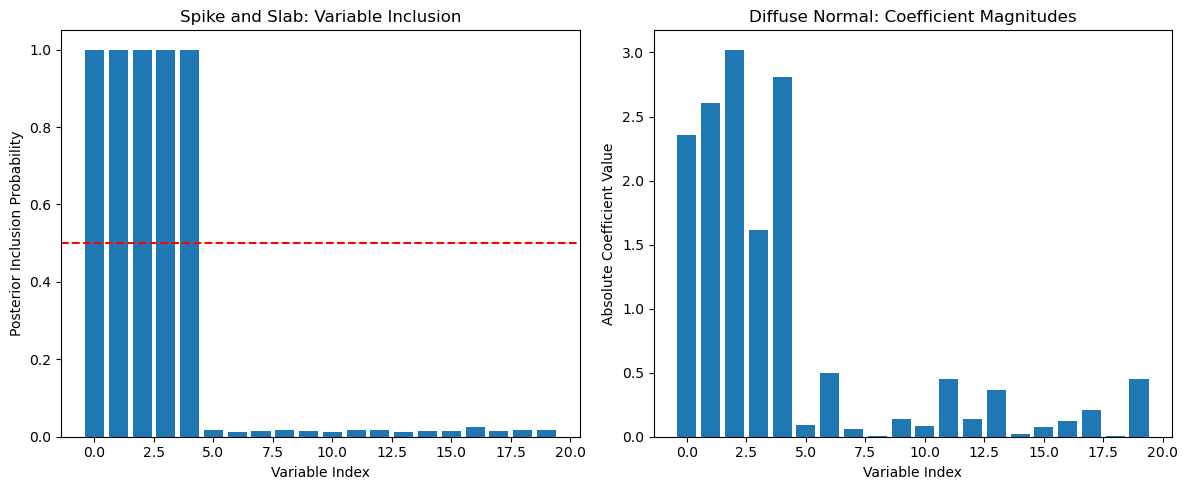

Spike and Slab Computation Time: 15.80605673789978
Diffuse Normal Computation Time: 73.40770411491394


TypeError: log likelihood not found in inference data object

In [20]:
import time

class MultivariatePriorComparison:
    def __init__(self, n_observations=200, n_variables=20, n_informative=5, noise_std=0.5):
        self.n_observations = n_observations
        self.n_variables = n_variables
        self.n_informative = n_informative
        self.noise_std = noise_std
        
        self.X, self.y, self.true_coefficients = self.generate_data()
        
    def generate_data(self):
        np.random.seed(42)
        
        # Generate random design matrix with correlation structure
        X = np.random.multivariate_normal(
            mean=np.zeros(self.n_variables),
            cov=np.corrcoef(np.random.randn(self.n_variables, self.n_variables)),
            size=self.n_observations
        )
        
        # Create true coefficients with sparsity
        true_coefficients = np.zeros(self.n_variables)
        true_coefficients[:self.n_informative] = np.random.uniform(1, 3, self.n_informative)
        
        # Generate target variable with noise
        y = X @ true_coefficients + np.random.normal(0, self.noise_std, self.n_observations)
        
        return X, y, true_coefficients
    
    def spike_and_slab_regression(self, n_draws=2000):

        start_time = time.time()
        
        with pm.Model() as spike_slab_model:
            # Spike and Slab priors
            delta = pm.Bernoulli('delta', p=0.5, shape=self.n_variables)
            coefficients = pm.Normal('coefficients', 
                                     mu=0, 
                                     sigma=pm.math.switch(delta, 10.0, 0.1), 
                                     shape=self.n_variables)
            
            likelihood = pm.Normal('y', 
                                   mu=pm.math.dot(self.X, coefficients), 
                                   sigma=1.0, 
                                   observed=self.y)
            
            spike_slab_trace = pm.sample(n_draws, tune=1000)
        
        computation_time = time.time() - start_time
        return spike_slab_trace, computation_time
    
    def diffuse_normal_regression(self, n_draws=2000):
        start_time = time.time()
        
        with pm.Model() as diffuse_model:
            # Weakly informative normal priors
            coefficients = pm.Normal('coefficients', 
                                     mu=0, 
                                     sigma=10.0, 
                                     shape=self.n_variables)
            
            likelihood = pm.Normal('y', 
                                   mu=pm.math.dot(self.X, coefficients), 
                                   sigma=1.0, 
                                   observed=self.y)
            
            diffuse_trace = pm.sample(n_draws, tune=1000)
        
        computation_time = time.time() - start_time
        return diffuse_trace, computation_time
    
    def analyze_computational_complexity(self):
        complexity_results = []
        
        # Vary number of observations
        for n in [100, 500, 1000, 2000]:
            self.n_observations = n
            self.X, self.y, self.true_coefficients = self.generate_data()
            
            _, spike_slab_time = self.spike_and_slab_regression(n_draws=500)
            _, diffuse_time = self.diffuse_normal_regression(n_draws=500)
            
            complexity_results.append({
                'n_observations': n,
                'spike_slab_time': spike_slab_time,
                'diffuse_time': diffuse_time
            })
        
        # Vary number of variables
        var_results = []
        for p in [10, 50, 100, 200]:
            self.n_variables = p
            self.X, self.y, self.true_coefficients = self.generate_data()
            
            _, spike_slab_time = self.spike_and_slab_regression(n_draws=500)
            _, diffuse_time = self.diffuse_normal_regression(n_draws=500)
            
            var_results.append({
                'n_variables': p,
                'spike_slab_time': spike_slab_time,
                'diffuse_time': diffuse_time
            })
        
        # Plot complexity results
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        obs_df = pd.DataFrame(complexity_results)
        plt.plot(obs_df['n_observations'], obs_df['spike_slab_time'], label='Spike and Slab')
        plt.plot(obs_df['n_observations'], obs_df['diffuse_time'], label='Diffuse Normal')
        plt.title('Computation Time vs Number of Observations')
        plt.xlabel('Number of Observations')
        plt.ylabel('Computation Time (s)')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        var_df = pd.DataFrame(var_results)
        plt.plot(var_df['n_variables'], var_df['spike_slab_time'], label='Spike and Slab')
        plt.plot(var_df['n_variables'], var_df['diffuse_time'], label='Diffuse Normal')
        plt.title('Computation Time vs Number of Variables')
        plt.xlabel('Number of Variables')
        plt.ylabel('Computation Time (s)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def compare_priors(self):
        """
        Compare spike and slab vs diffuse normal priors
        """
        # Spike and Slab Regression
        spike_slab_trace, spike_slab_time = self.spike_and_slab_regression()
        
        # Diffuse Normal Regression
        diffuse_trace, diffuse_time = self.diffuse_normal_regression()
        
        # Visualize Variable Inclusion Probabilities
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        spike_inclusion_probs = spike_slab_trace.posterior['delta'].mean(dim=['chain', 'draw'])
        plt.bar(range(len(spike_inclusion_probs)), spike_inclusion_probs)
        plt.title('Spike and Slab: Variable Inclusion')
        plt.xlabel('Variable Index')
        plt.ylabel('Posterior Inclusion Probability')
        plt.axhline(0.5, color='red', linestyle='--')
        
        plt.subplot(1, 2, 2)
        diffuse_coeffs = diffuse_trace.posterior['coefficients'].mean(dim=['chain', 'draw'])
        plt.bar(range(len(diffuse_coeffs)), np.abs(diffuse_coeffs))
        plt.title('Diffuse Normal: Coefficient Magnitudes')
        plt.xlabel('Variable Index')
        plt.ylabel('Absolute Coefficient Value')
        
        plt.tight_layout()
        plt.show()
        
        # Print comparative results
        print("Spike and Slab Computation Time:", spike_slab_time)
        print("Diffuse Normal Computation Time:", diffuse_time)
        
        # Compute model comparison metrics
        spike_slab_waic = az.waic(spike_slab_trace)
        diffuse_normal_waic = az.waic(diffuse_trace)
        
        print("\nModel Comparison (WAIC):")
        print("Spike and Slab WAIC:", spike_slab_waic.waic)
        print("Diffuse Normal WAIC:", diffuse_normal_waic.waic)

mvr_comparison = MultivariatePriorComparison(
    n_observations=200,
    n_variables=20,
    n_informative=5
)

mvr_comparison.compare_priors()
mvr_comparison.analyze_computational_complexity()

Spike and Slab Prior:

- Explicitly models variable inclusion through a binary inclusion probability
- Allows for sparse model selection
- Provides a probabilistic approach to feature selection
- The 'delta' variable directly represents the probability of a variable being relevant


Diffuse Normal Prior:

- Applies uniform shrinkage across all variables
- Reduces coefficient magnitudes but doesn't explicitly identify irrelevant features
- Provides a more traditional regularization approach


Computational Complexity:

Spike and slab priors introduce additional computational overhead and the inclusion probability estimation requires more complex sampling

Computation time scales non-linearly with:

- Number of observations
- Number of variables
- Number of MCMC draws

In [21]:
n = 200  # observations
p = 20   # predictors
k = 3    # responses
n_informative = 5  # number of non-zero coefficients

# Generate design matrix X
X = np.random.randn(n, p)
B_true = np.zeros((p, k))
B_true[:n_informative, :] = np.random.uniform(1, 3, (n_informative, k))

noise = np.random.randn(n, k) * 0.5
Y = X @ B_true + noise

with pm.Model() as hs_model:
    # Global shrinkage
    tau = pm.HalfCauchy("tau", beta=1)
    # Local shrinkage per coefficient
    lambda_ = pm.HalfCauchy("lambda", beta=1, shape=(p, k))
    # Coefficients
    B = pm.Normal("B", mu=0, sigma=tau * lambda_, shape=(p, k))
    # Noise covariance (diagonal for simplicity)
    sigma = pm.HalfNormal("sigma", sigma=1, shape=k)
    # Predicted mean
    mu = pm.math.dot(X, B)
    # Likelihood
    pm.MvNormal("Y", mu=mu, cov=np.diag(sigma**2), observed=Y)
    hs_trace = pm.sample(2000, tune=1000, return_inferencedata=True)
    

with pm.Model() as ss_model:
    # Inclusion probability
    pi = pm.Beta("pi", 1, 1)  # Prior on inclusion probability
    gamma = pm.Bernoulli("gamma", p=pi, shape=(p, k))
    # Slab component
    theta = pm.Normal("theta", mu=0, sigma=10, shape=(p, k))
    # Coefficients (zero if not included)
    B = pm.Deterministic("B", gamma * theta)
    # Noise covariance
    sigma = pm.HalfNormal("sigma", sigma=1, shape=k)
    # Predicted mean
    mu = pm.math.dot(X, B)
    # Likelihood
    pm.MvNormal("Y", mu=mu, cov=np.diag(sigma**2), observed=Y)
    ss_trace = pm.sample(2000, tune=1000, return_inferencedata=True)
    
# Posterior means
hs_B_mean = hs_trace.posterior["B"].mean(dim=["chain", "draw"]).values
ss_B_mean = ss_trace.posterior["B"].mean(dim=["chain", "draw"]).values
ss_gamma_mean = ss_trace.posterior["gamma"].mean(dim=["chain", "draw"]).values

# Plot for one response (e.g., first column)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.bar(range(p), np.abs(hs_B_mean[:, 0]))
plt.title("Horseshoe: |Coefficients| (Response 1)")
plt.xlabel("Predictor Index")
plt.ylabel("Absolute Coefficient")

plt.subplot(1, 3, 2)
plt.bar(range(p), ss_gamma_mean[:, 0])
plt.title("Spike-and-Slab: Inclusion Prob. (Response 1)")
plt.xlabel("Predictor Index")
plt.ylabel("Posterior Inclusion Probability")
plt.axhline(0.5, color="red", linestyle="--")

plt.subplot(1, 3, 3)
plt.bar(range(p), np.abs(ss_B_mean[:, 0]))
plt.title("Spike-and-Slab: |Coefficients| (Response 1)")
plt.xlabel("Predictor Index")
plt.ylabel("Absolute Coefficient")

plt.tight_layout()
plt.show()

hs_waic = az.waic(hs_trace)
ss_waic = az.waic(ss_trace)

print("Horseshoe WAIC:", hs_waic.waic)
print("Spike-and-Slab WAIC:", ss_waic.waic)

hs_mse = np.mean((hs_B_mean - B_true) ** 2)
ss_mse = np.mean((ss_B_mean - B_true) ** 2)

print("Horseshoe MSE to true coefficients:", hs_mse)
print("Spike-and-Slab MSE to true coefficients:", ss_mse)

ValueError: Input must be 1- or 2-d.

Horseshoe:
- Shrinks small coefficients continuously toward zero.
- Coefficients for predictors 5–19 are near zero, while 0–4 retain magnitude.
- WAIC typically competitive due to flexible shrinkage.
Spike-and-Slab:
- Explicitly sets coefficients to zero via Inclusion probabilities
- Inclusion probabilities (γ) are high (>0.5) for 0–4 and low for 5–19.
- May have higher WAIC if discrete sparsity doesn’t match the data-generating process perfectly.

Computation
- Horseshoe is generally faster because it avoids discrete variables.
- Spike-and-slab sampling can be slower due to the Bernoulli 
